<a href="https://colab.research.google.com/github/shritimukherjee27/geotask/blob/main/geotask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- In this project the data used is from Google Earth Engine, User must provide with three inputs

(i) Geojson
{ii) Start and End Date
(iii) Interval of images
  
  ****************************************************************************
  Make sure to instal geemap and geojson libraries-->

<!-- In this project the data used is from Google Earth Engine, User must provide with three inputs
(i) Geojson
{ii) Start and End Date
(iii) Interval of images
  
  ****************************************************************************
  Make sure to instal geemap and geojson libraries-->

In [2]:
# !pip install geemap
# !pip install geojson


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import geojson
import geemap
import ipywidgets as widgets

import ee
ee.Authenticate()

In [ ]:
with open('/content/map.geojson') as f:
    geojson_data = geojson.load(f)


In [ ]:
ee.Initialize(project='geotask-424116')


In [ ]:
vis_param_L457 = {'min': 0, 'max': 30000, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for landsat raw image visualization
sc_vis_param_L457 = {'min':0, 'max':0.3, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for scaled landsat image visualization

vis_param_L8 = {'min': 0, 'max': 30000, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for landsat raw image visualization
sc_vis_param_L8 = {'min':0, 'max':0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for scaled landsat image visualization

zoom = 8
width="40%"
center = [29.9617498,61.7604367]

In [ ]:
geojson_data['features'][0]['geometry']['coordinates']

[[[77.625121, 12.957113],
  [77.625121, 12.902361],
  [77.690063, 12.902361],
  [77.690063, 12.957113],
  [77.625121, 12.957113]]]

In [ ]:
aoi = ee.Geometry.Polygon(geojson_data['features'][0]['geometry']['coordinates'], None, False)
display(aoi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              77.625121,
              12.957113
            ],
            [
              77.625121,
              12.902361
            ],
            [
              77.690063,
              12.902361
            ],
            [
              77.690063,
              12.957113
            ],
            [
              77.625121,
              12.957113
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

In [ ]:
##  Cloud masking algorithms for Landsat 4, 5, 7 surface reflectance
def maskL457sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(ee.Number.parse('11111', 2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)    # The QA_RADSAT band indicates which sensor band(s) are saturated.presence of cloud or bad saturation

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks., qa removes zero
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)


#  Cloud masking algorithms for Landsat 8 surface reflectance
def maskL8sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)

In [ ]:
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1995-02-20') \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(L5Col_test, sc_vis_param_L457, name="TEST")
Map

Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
 display(L5Col_test.bandNames())

In [ ]:
nir_test = L5Col_test.select('SR_B5')
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(nir_test, name="NIR")
Map

Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
# Load ImageCollection from Earth Engine using its asset ID
# For Example, landsat collection on earth engine: https://developers.google.com/earth-engine/datasets/catalog/landsat

L5Col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 5
L7Col = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 7
L8Col = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 8

In [ ]:
def MaskWaterFunc(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))
  return waterBody.rename("WATER")

In [ ]:
waterMask = {}

for year in range(1985, 2025, 5):

  # Years using Landsat-5 image collection
  if year in [1985, 1990, 1995]:
    imgCollection = L5Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')    # filter collection by date
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)                              # run cloud masking and scale the pixel values
    imgAgg = imgCloudMask.median().clip(aoi)                                            # aggregate the image and clip over AOI

    display(imgAgg)                                                                     # diplay "imgAgg" image properties for each year's image
    key = f'waterMask_{year}'                                                           # initialize key

    # Apply Extract Water Mask Algorithm to the images.
    waterBody = MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')  # Run MaskWaterFunc algorithm to mask water bodies
    waterMask[key]=[imgAgg, waterBody]                                                  # save satellite image, and water body mask into dictionary

  # Years using Landsat-7 image collection
  if year in [2000, 2005, 2010]:
    imgCollection = L7Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')]

  # Years using Landsat-8 image collection
  if year in [2015, 2020]:
    imgCollection = L8Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL8sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B2', greenBand = 'SR_B3', redBand = 'SR_B4', nirBand = 'SR_B5', swirBand = 'SR_B6')]

In [ ]:
def MaskWaterFunc_TEST(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))

  # Return all data for testing purpose
  return waterBody.rename("WATER"), MNDWI.rename("MNDWI"), NDVI.rename("NDVI"), EVI.rename("EVI")


In [ ]:
def MaskWaterFunc_TEST(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))

  # Return all data for testing purpose
  return waterBody.rename("WATER"), MNDWI.rename("MNDWI"), NDVI.rename("NDVI"), EVI.rename("EVI")


In [ ]:
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1997-06-20') \
                .filterBounds(aoi) \
                .filter(ee.Filter.gt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()  \
                .clip(aoi)

display(L5Col_test)


In [ ]:

# Apply Extract Water Mask Algorithm to the images.
waterBody, mndwi, ndvi, evi = MaskWaterFunc_TEST(L5Col_test, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')


In [ ]:

# Visualize all Layers
Map = geemap.Map(center = center, zoom = zoom, width = width)

Map.addLayer(L5Col, sc_vis_param_L457, name="L8 data")
Map.addLayer(waterBody, name="Water Body")
Map.addLayer(ndvi,{'min': -1, 'max': 1, 'palette': 'Greens'}, name="NDVI")
Map.addLayer(mndwi, {'min': -1, 'max': 1, 'palette': 'Blues'}, name="MNDWI")
Map.addLayer(evi, {'min': -1, 'max': 1, 'palette': 'turbo'}, name="EVI")

Map

Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_1990'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_1990'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map


Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_2020'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_2020'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map

Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
print(list(waterMask.keys()))

['waterMask_1985', 'waterMask_1990', 'waterMask_1995', 'waterMask_2000', 'waterMask_2005', 'waterMask_2010', 'waterMask_2015', 'waterMask_2020']


In [ ]:
# function to calculate area of geometry in sq km. and add property to ee feature.

def add_area_property(feature):
    area = feature.geometry().area(maxError=1).divide(ee.Number(1000000))
    # The maxError=1 is setting the maximum allowable error for the area calculation to be 1 meter.
    return feature.set('area', area)

# Looping through each water mask raster to convert rasters to vector
watermaskVector = {}
for item in list(waterMask.keys()):
  # https://gis.stackexchange.com/a/413138/126926
  wmReduced = waterMask[item][1].reduceNeighborhood(ee.Reducer.mode(), ee.Kernel.circle(5))    # filter operation, to remove isolated pixels
  # Raster to Vector operation
  vectors = ee.Image(wmReduced).selfMask().reduceToVectors(
    geometry=aoi,
    scale= 30,
    eightConnected= True,
    maxPixels= 1e10,
    tileScale= 16
  )

  # calculate area of each vectors
  vectorAreaProp = vectors.map(add_area_property)           # add 'area' property by calculating from geometry
  vectorWaterMask = (vectorAreaProp.sort('area', False))    # sort the features within featureCollection by 'area' property in descending order
  vectorWaterMask = vectorWaterMask.limit(20)               # only top 'n' largest water bodies will be selected
  display(vectorWaterMask)

  # Add to the dictionary
  watermaskVector[item] = vectorWaterMask

In [ ]:
# Display the extracted vector water body layer

MapFinal = geemap.Map(center = center, zoom = 10, height="800px", width = "50%")



In [ ]:
for layer in watermaskVector:
    # Check if the image has bands before adding layers
    if waterMask[str(layer)][0].bandNames().size().getInfo() > 0:
        MapFinal.addLayer(waterMask[str(layer)][0], sc_vis_param_L457, name=layer.split("_")[1]+"_Landsat")   # satellite image
        MapFinal.addLayer(watermaskVector[layer], name=layer)
    else:
        watermaskVector.pop(layer)

MapFinal


Map(center=[29.9617498, 61.7604367], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
watermaskVector

{'waterMask_1990': <ee.featurecollection.FeatureCollection at 0x7b51a01668f0>,
 'waterMask_1995': <ee.featurecollection.FeatureCollection at 0x7b51a01b0a30>,
 'waterMask_2000': <ee.featurecollection.FeatureCollection at 0x7b51a01b2410>,
 'waterMask_2005': <ee.featurecollection.FeatureCollection at 0x7b51a01b3d60>,
 'waterMask_2010': <ee.featurecollection.FeatureCollection at 0x7b519bf157b0>,
 'waterMask_2015': <ee.featurecollection.FeatureCollection at 0x7b519bf17190>,
 'waterMask_2020': <ee.featurecollection.FeatureCollection at 0x7b519bf28bb0>}

In [ ]:
for key, image in waterMask.items():
    bands = image[0].bandNames().getInfo()
    if bands is None :
        waterMask.pop(key)
    else:
        print(f"{key}: {bands}")

waterMask_1985: []
waterMask_1990: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
waterMask_1995: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
waterMask_2000: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
waterMask_2005: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
waterMask_2010: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'

In [ ]:
# Demo: Traversing through featureCollection -> feature -> properties

# Take feature collection item
featureCol = watermaskVector['waterMask_2020']
display(featureCol)

# Display feature
feature = featureCol.first()
display(feature)

# Display feature as dictionary
dictx = feature.toDictionary()    # type: <class 'ee.dictionary.Dictionary'>
display(dictx)

# Display area property
  # dictx.get('area')             # possible way, but not preferred
  # .getInfo() changes the ee.dictionary.Dictionary asset to python dictionary which we can manipulate in our program
dictx.getInfo()['area']

0.10590505388910725

In [ ]:
waterArea = []

keys = list(watermaskVector.keys())
print(keys)
for item in keys:
  areaSum = watermaskVector[item].reduceColumns(ee.Reducer.sum(),['area']).get('sum').getInfo()
  waterArea.append(areaSum)

# .reduceColumns(ee.Reducer.sum(),['area']), applies ee.Reducer.sum() to add all 'area' field, and appends a 'sum' attribute in the dataset.
#  We can then retrieve this 'sum' value using .getInfo()

['waterMask_1990', 'waterMask_1995', 'waterMask_2000', 'waterMask_2005', 'waterMask_2010', 'waterMask_2015', 'waterMask_2020']


In [ ]:
print(waterArea)

[1.497483316015281, 2.271153870089969, 1.8904451214509406, 1.9298306474444682, 1.5447394842793778, 1.2375494913895966, 0.24420170966745058]


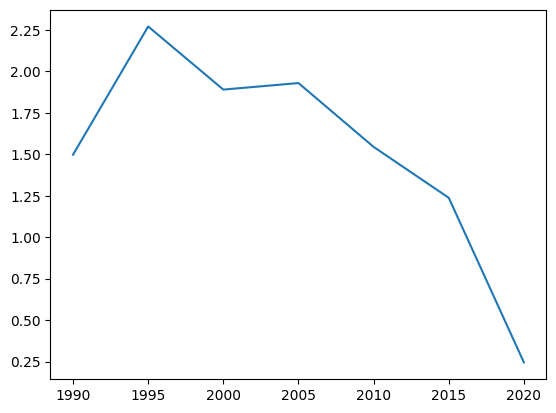

In [ ]:
time_frame = list(range(1990, 2025, 5))
plt.plot(time_frame, waterArea)